In this notebook one convolutional network is trained and evaluated as an example.
The following setup were tested and saved: 


1. 
n_inputs = (1, 45, 90)  

conv_layers_params = [
    (8, (8, 16), 1, 'same', 11), 
    (16, (4, 8), 1, 'same', 4)   ]


nodes_per_layer = [64, 32]


saved under "trained_models/Complex_48_LR_L.pth"

2. 
n_inputs = (1, 90, 180)  


conv_layers_params = [
    (8, (8, 16), 1, 'same', 11), 
    (16, (4, 8), 1, 'same', 4)   ]


nodes_per_layer = [64, 32]


saved under "trained_models/Complex_48_HR_L.pth"

3.
n_inputs = (1, 45, 90)  


conv_layers_params = [
    (4, 5, 1, 2, 3),  
    (8, 5, 1, 2, 3), 
    (16, 5, 1, 2, 3)   ]


nodes_per_layer = [100, 10]


saved under "trained_models/Complex_5_LR_L.pth"

4.
n_inputs = (1, 90, 180)  


conv_layers_params = [
    (4, 5, 1, 2, 3),  
    (8, 5, 1, 2, 3), 
    (16, 5, 1, 2, 3)   ]


nodes_per_layer = [100, 10]


saved under "trained_models/Complex_5_HR_L.pth"

In [1]:
import xarray as xr
import numpy as np
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from copy import deepcopy
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import random

In [2]:
from modules import *

/Users/ferdinand/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403251597/work/aten/src/ATen/native/Convolution.cpp:1041.)
  return F.conv2d(input, weight, bias, self.stride,


In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set a seed value
seed_value = 55
set_seed(seed_value)

In [4]:
# Set device to cpu
device = "cpu"
print(device)

mps


### Low Res

Original data shape: (24, 181, 45, 90)
Reshaped Data shape: (4344, 45, 90)
Repeated years shape: (4344,)
Train DataLoader size: 3040
Validation DataLoader size: 652
Test DataLoader size: 652
Train x mean, x std: tensor(278.5204) tensor(20.6051)
Train y mean, y std: tensor(2009.1237) tensor(51.9506)
Validation x mean, x std: tensor(278.5204) tensor(20.6051)
Validation y mean, y std: tensor(2009.1237) tensor(51.9506)
Test x mean, x std: tensor(278.5204) tensor(20.6051)
Test y mean, y std: tensor(2009.1237) tensor(51.9506)
Y min, max: 1920 2100
Input shape: torch.Size([64, 45, 90])
Target shape: torch.Size([64, 1])
tensor(-1.6193)


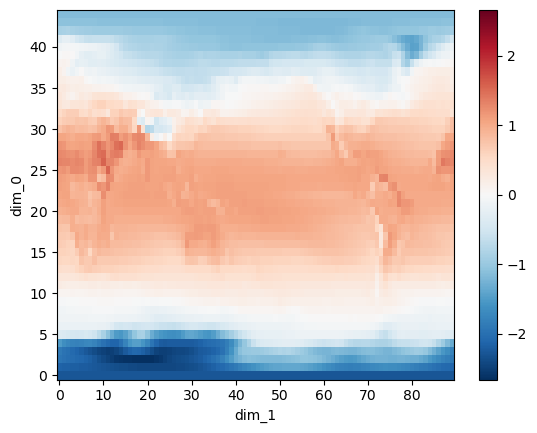

tensor(1925.)


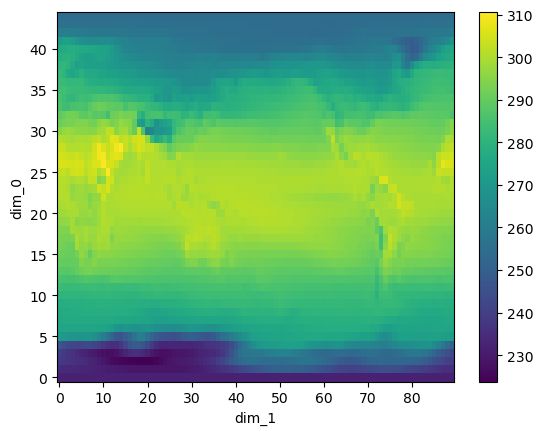

 10%|█         | 103/1000 [01:44<15:14,  1.02s/it]

Early stopping at epoch 103
Best model saved to Complex_48_LR_L.pth


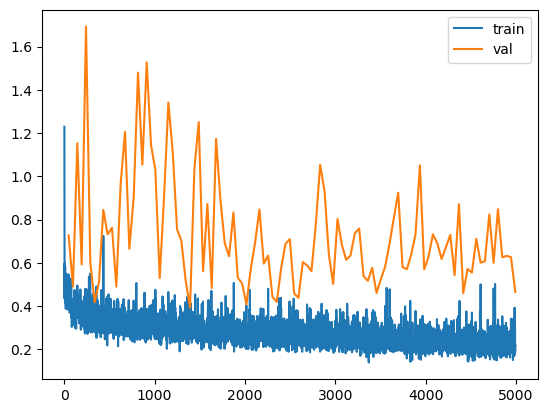

R2:  0.8569684798850312
MSE:  0.15614073
RMSE:  0.39514646
MSR years:  421.40265
RMSE years:  20.528093
Pearson correlation and p-vale:  0.9287042805946324 3.049932682735638e-282
Spearman correlation and p-value:  0.886077357127813 3.182491644712122e-219
R2:  0.6942289532216612
MSE:  0.29678524
RMSE:  0.54478
MSR years:  800.98315
RMSE years:  28.301645
Pearson correlation and p-vale:  0.8343176622352375 2.9355676367212443e-170
Spearman correlation and p-value:  0.8718808745954582 1.0461773711371104e-203


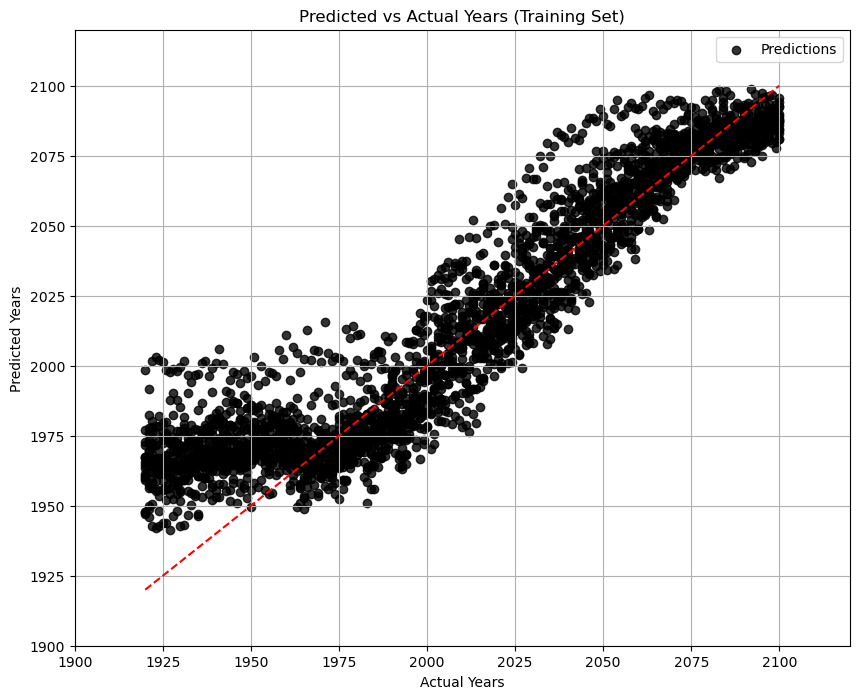

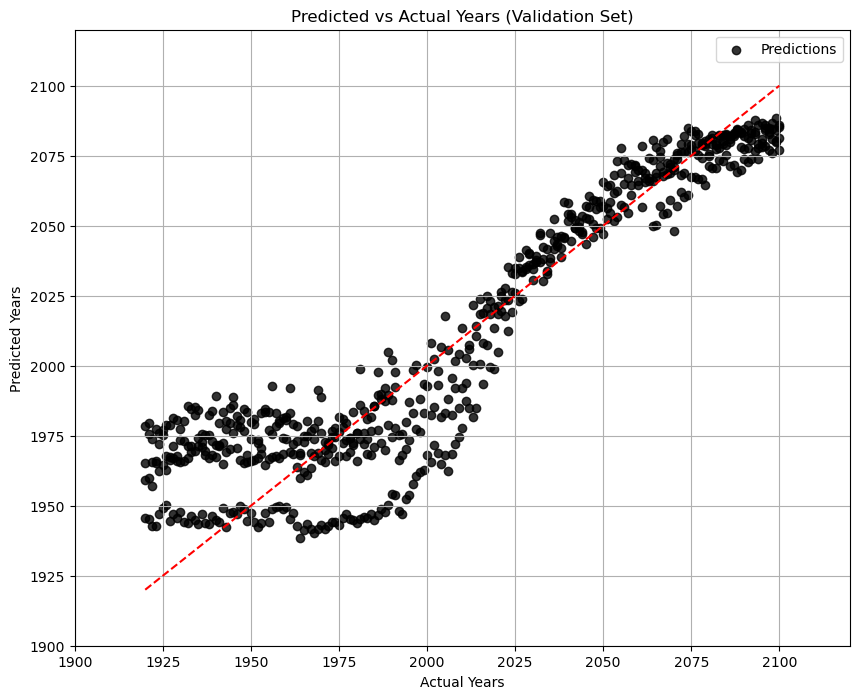

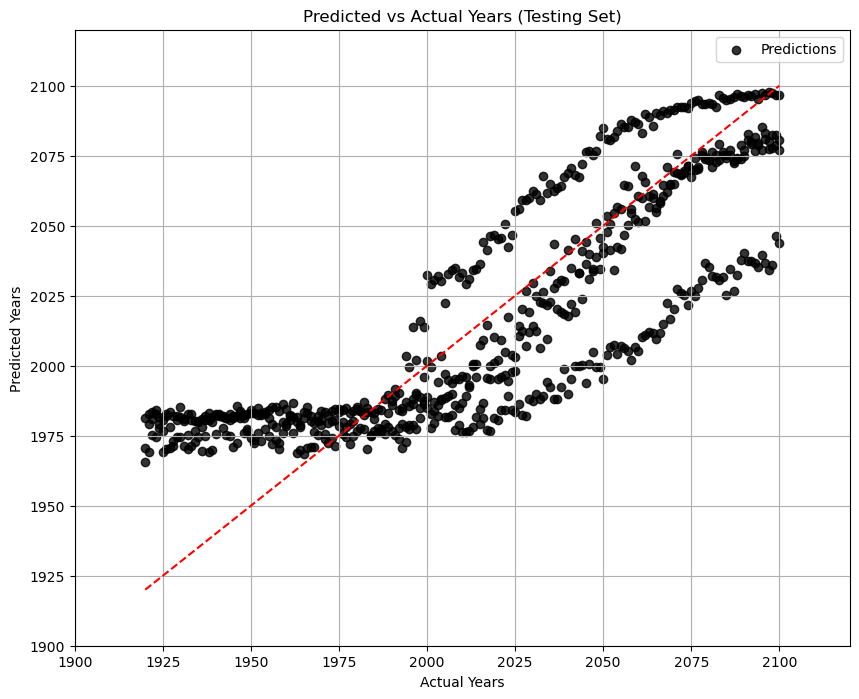

In [13]:
# Load the NetCDF file using netCDF4
file_path = 'Data/combined_dataset_LR.nc'

# Prepare datasets and loader
train_loader, val_loader, test_loader, train_x_stats, train_y_stats, val_x_stats, val_y_stats, test_x_stats, test_y_stats = prepare_datasets_L(file_path, batch_size=64, train_ratio=0.7, val_ratio=0.15, shuffle = True, info=True)

# Define input shape: (channels, height, width)
n_inputs = (1, 45, 90)  

# Define convolutional layers parameters: (out_channels, kernel_size, stride, padding, pool_kernel)
conv_layers_params = [
    (8, (8, 16), 1, 'same', 11), 
    (16, (4, 8), 1, 'same', 4)   
]

# Define the number of nodes in each hidden layer
nodes_per_layer = [64, 32]

# Initialize model
model = ConvModel(n_inputs, conv_layers_params, nodes_per_layer, use_dropout=False, dropout_prob=0.1, use_batchnorm=True, output_size=1, pooling_type='avg' )

trained_model, loss_vals, val_loss_vals = train_model(model, train_loader, val_loader, device, "trained_models/Complex_48_LR_L.pth", learning_rate=1e-3, patience=75, min_delta=0.001, min_epochs=50, n_epochs=1000, l2_lambda=1e-2, use_l2_reg=False, info=True)

# Evaluate model
r2, mse, pearson_corr = evaluate_model(trained_model, val_loader, val_y_stats, device, info=True)
# Evaluate model

r2, mse, pearson_corr = evaluate_model(trained_model, test_loader, test_y_stats, device, info=True)
# Plot predictions

# Plot for training set
plot_predictions(trained_model, device,  train_loader, train_y_stats, "Predicted vs Actual Years (Training Set)")

# Plot for validation set
plot_predictions(trained_model ,device, val_loader, train_y_stats, "Predicted vs Actual Years (Validation Set)")

# Plot for testing set
plot_predictions(trained_model, device, test_loader, train_y_stats, "Predicted vs Actual Years (Testing Set)")

Model loaded from Complex_48_LR_L.pth
R2:  0.8569685730914791
MSE:  0.15614064
RMSE:  0.39514634
MSR years:  421.40237
RMSE years:  20.528088
Pearson correlation and p-vale:  0.9287042966518737 3.049717645452521e-282
Spearman correlation and p-value:  0.886077357127813 3.182491644712122e-219
R2:  0.6942289086052239
MSE:  0.29678527
RMSE:  0.54478
MSR years:  800.98315
RMSE years:  28.301645
Pearson correlation and p-vale:  0.8343176344425959 2.935713322455204e-170
Spearman correlation and p-value:  0.8718808745954582 1.0461773711371104e-203


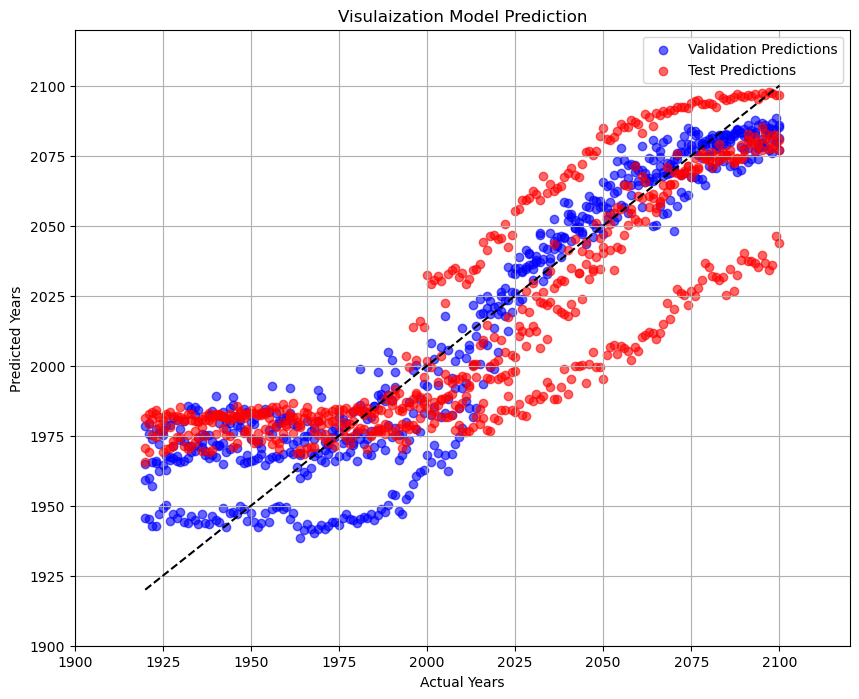

In [14]:

# Load the NetCDF file using netCDF4
file_path = 'Data/combined_dataset_LR.nc'

# Prepare datasets and loader
train_loader, val_loader, test_loader, train_x_stats, train_y_stats, val_x_stats, val_y_stats, test_x_stats, test_y_stats = prepare_datasets_L(file_path, batch_size=128, train_ratio=0.7, val_ratio=0.15, shuffle = True, info=False)

# Define input shape: (channels, height, width)
n_inputs = (1, 45, 90)  

# Define convolutional layers parameters: (out_channels, kernel_size, stride, padding, pool_kernel)
conv_layers_params = [
    (8, (8, 16), 1, 'same', 11), 
    (16, (4, 8), 1, 'same', 4)   
]

# Define the number of nodes in each hidden layer
nodes_per_layer = [64, 32]

# Initialize model
Model = ConvModel(n_inputs, conv_layers_params, nodes_per_layer, use_dropout=False, dropout_prob=0.1, use_batchnorm=True, output_size=1, pooling_type='avg' )

# load the model
checkpoint_path = 'trained_models/Complex_48_LR_L.pth'

checkpoint = torch.load(checkpoint_path)
Model.load_state_dict(checkpoint['vis_model_state_dict'])

print('Model loaded from', checkpoint_path)

Model.eval()

# Evaluate the model
r2, mse, pearson_corr = evaluate_model(Model, val_loader, val_y_stats, device, info=True)

# Evaluate the model
r2, mse, pearson_corr = evaluate_model(Model, test_loader, test_y_stats, device, info=True)
